In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%matplotlib inline
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
from pandas.plotting import parallel_coordinates


In [2]:
#load data
#dataset can be found at: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview
articles = pd.read_csv('../../data/articles.csv')
customers = pd.read_csv('../../data/customers.csv')
transactions = pd.read_csv('../../data/transactions_train.csv')

## Data Preperation

In [3]:
#group transactions into baskets (by daily customer purchases)
baskets = transactions.groupby(['customer_id', 't_dat'])['article_id'].apply(lambda x: ','.join(x.astype(str))).reset_index()

In [4]:
baskets['t_dat'] = pd.to_datetime(baskets['t_dat'])
baskets = baskets.sort_values(by=['t_dat'], ascending=True)

In [5]:
#create list of all purchase baskets
def create_baskets_list (baskets, column_name='article_id'):
        baskets_list = []

        for i in baskets[column_name].values.tolist():
                #only look at baskets with 2 or more items
                if len(i.split(",")) > 1:                       
                        baskets_list.append(i.split(","))
                        
        return baskets_list

In [6]:
#map a list of article_id to another parameter
def map_baskets(baskets, map):
    mapped_baskets = []
    for basket in baskets:
        basket_list = []
        for item in basket:
            basket_list.append(map[int(item.strip())])
        mapped_baskets.append(basket_list)
    
    return mapped_baskets

In [7]:
baskets_list = create_baskets_list(baskets)

#map of article id and product type
product_type_map = dict(zip(articles.article_id.values, articles.product_type_name.values))

purchase_list = map_baskets(baskets_list, product_type_map)

## Frequent item sets (with product types)

In [8]:
#applies the apriori algorithm to a list of baskets
def apply_apriori(data, min_sup=0.01):
    #preparing the data
    te = TransactionEncoder()
    te_ary = te.fit(data).transform(data)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    #run apriori algorithm
    frequent_tr_encoded = apriori(df, min_support=min_sup, use_colnames=True)

    #cleaning up the data
    frequent_itemsets = frequent_tr_encoded.sort_values(by=['support'], ascending=False)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

    return frequent_itemsets

In [9]:
frequent_product_types = apply_apriori(purchase_list)

In [10]:
#lets look at all the frequent itemsets 
frequent_product_types

support                    itemsets  length
34   0.301383                  (Trousers)       1
10   0.222381                     (Dress)       1
29   0.220086                   (Sweater)       1
32   0.180339                   (T-shirt)       1
33   0.155071                       (Top)       1
..        ...                         ...     ...
12   0.010337           (Hair/alice band)       1
144  0.010199   (Trousers, Top, Vest top)       3
132  0.010190       (Dress, Sweater, Top)       3
68   0.010056  (Dress, Jumpsuit/Playsuit)       2
131  0.010037    (Dress, Skirt, Trousers)       3

[145 rows x 3 columns]

In [11]:
#itemsets with 2 items
frequent_product_types[ (frequent_product_types['length'] == 2) ]

support                       itemsets  length
109  0.077951            (Sweater, Trousers)       2
41   0.072424  (Bikini top, Swimwear bottom)       2
77   0.060236              (Dress, Trousers)       2
116  0.057402            (T-shirt, Trousers)       2
119  0.053178                (Trousers, Top)       2
..        ...                            ...     ...
105  0.010666               (Socks, Sweater)       2
45   0.010595              (Sweater, Blazer)       2
120  0.010553        (Underwear bottom, Top)       2
42   0.010355          (Bikini top, T-shirt)       2
68   0.010056     (Dress, Jumpsuit/Playsuit)       2

[86 rows x 3 columns]

In [12]:
#applies association rules to frequent itemsets
def apply_association_rules(df, min_thresh=0.4, met='confidence'):
    return association_rules(df, metric=met , min_threshold=min_thresh).sort_values(by=['confidence'], ascending=False)

In [13]:
apply_association_rules(frequent_product_types)

antecedents        consequents  antecedent support  \
1          (Swimwear bottom)       (Bikini top)            0.087251   
0               (Bikini top)  (Swimwear bottom)            0.087473   
11  (Dress, Swimwear bottom)       (Bikini top)            0.015921   
10       (Bikini top, Dress)  (Swimwear bottom)            0.016228   
2         (Underwear bottom)              (Bra)            0.090582   
3                   (Blazer)         (Trousers)            0.044468   
13       (Jumpsuit/Playsuit)            (Dress)            0.022973   
8          (Blouse, Sweater)         (Trousers)            0.031567   
12         (Blouse, T-shirt)         (Trousers)            0.025220   
9              (Blouse, Top)         (Trousers)            0.031759   
6                 (Cardigan)          (Sweater)            0.038820   
5         (Sweater, T-shirt)         (Trousers)            0.039981   
14         (Skirt, Trousers)            (Dress)            0.024761   
4             (Sweater, Top)         (Trousers)            0.042580   
7           (Dress, Sweater)         (Trousers)            0.037424   

    consequent support   support  confidence      lift  leverage  conviction  
1             0.087473  0.072424    0.830067  9.489455  0.064792    5.369924  
0             0.087251  0.072424    0.827965  9.489455  0.064792    5.305606  
11            0.087473  0.012747    0.800644  9.153093  0.011355    4.577387  
10            0.087251  0.012747    0.785504  9.002796  0.011331    4.255311  
2             0.112359  0.041088    0.453596  4.037011  0.030910    1.624514  
3             0.301383  0.020088    0.451746  1.498909  0.006686    1.274258  
13            0.222381  0.010056    0.437743  1.968434  0.004947    1.383031  
8             0.301383  0.013565    0.429727  1.425848  0.004051    1.225056  
12            0.301383  0.010690    0.423866  1.406401  0.003089    1.212594  
9             0.301383  0.013087    0.412074  1.367277  0.003515    1.188274  
6             0.220086  0.015818    0.407472  1.851425  0.007274    1.316249  
5             0.301383  0.016221    0.405726  1.346213  0.004172    1.175580  
14            0.222381  0.010037    0.405368  1.822853  0.004531    1.307732  
4             0.301383  0.017230    0.404655  1.342660  0.004397    1.173466  
7             0.301383  0.015051    0.402167  1.334403  0.003772    1.168581

## Seasonal patterns

split transactions into 4 seasons: spring(march-may), summer(june-august), fall(september-november), winter(december-february)

In [14]:
#create new columns corresponding to the month and season of transaction
def map_season(df, datetime_column):
    df['month'] = pd.DatetimeIndex(baskets[datetime_column]).month

    seasons = []

    for month in df['month']:
        if (month >= 3) and (month < 6):
            seasons.append('spring')
        elif (month >= 6) and (month < 9):
            seasons.append('summer')
        elif (month >= 9) and (month < 12):
            seasons.append('fall')
        else:
            seasons.append('winter')
    
    df['season'] = seasons

In [15]:
map_season(baskets, 't_dat')

In [16]:
baskets

customer_id      t_dat  \
971624   1b4ad1bb792824540e946a0b0753732b12a4e093838130... 2018-09-20   
5811242  a3a4bef27deb7e281bba5e69ec1e4ada1b92d0830f71b3... 2018-09-20   
5901446  a63a9c42f9842cf133395720e7b8ab036ac17e90315e8f... 2018-09-20   
6871699  c1a248efd4e623a732edd6a82c1b86f8855e39366f1b37... 2018-09-20   
3345344  5e718141459ee81cd3197c22a9486c8d85b2ac25ea5f6c... 2018-09-20   
...                                                    ...        ...   
900159   194200ea696f8e82e325c94736ba64067cd75a039589af... 2020-09-22   
4786982  871bce4bca27facb372fde060289617b935303d5636e21... 2020-09-22   
6341001  b2b1ca97a7561c08682032a8b6a0d0f2c76be0682c1105... 2020-09-22   
3201045  5a5972b26f99c8fefd7dc1a9ac9c2b899b75eed22d2226... 2020-09-22   
7631323  d7209ff49870888d00a6a5beaa8ee84fc1b1bdca8a2f3a... 2020-09-22   

                                                article_id  month season  
971624                                           561222001      9   fall  
5811242                                539723005,539723007      9   fall  
5901446  564787001,523489001,436083003,241412038,637661...      9   fall  
6871699  551989032,394522001,670655001,670655001,627389...      9   fall  
3345344  652708001,680810002,655855001,652671001,652696001      9   fall  
...                                                    ...    ...    ...  
900159                                           399256001      9   fall  
4786982            889036004,895028001,786022008,850917001      9   fall  
6341001                                843597002,843597002      9   fall  
3201045                      893197001,876926001,862272004      9   fall  
7631323  898713001,898713001,806807001,806807001,874754...      9   fall  

[9080179 rows x 5 columns]

In [17]:
seasons = ['spring', 'summer', 'fall', 'winter']
seasonal_baskets = []

#create a list of dataframe where each element corresponds to the baskets of each month 
for s in seasons:
    seasonal_baskets.append(baskets[baskets['season'] == s])

In [18]:
seasonal_purchases = []

#create a list where each element is a list of transactions for a given season
for basket in seasonal_baskets:
    seasonal_purchases.append(map_baskets(create_baskets_list(basket), product_type_map))

In [19]:
seasonal_supports = {}
seasonal_rules = {}

#apply the apriori algorithm and association rules to each season
#store the results in a dictionary
for key, value in zip(seasons, seasonal_purchases):
    apr = apply_apriori(value)
    seasonal_supports[key] = apr
    seasonal_rules[key] = apply_association_rules(apr, 0.45)

In [20]:
seasonal_rules['summer']

antecedents        consequents  antecedent support  \
0                  (Bikini top)  (Swimwear bottom)            0.138534   
1             (Swimwear bottom)       (Bikini top)            0.139896   
5          (Bikini top, Shorts)  (Swimwear bottom)            0.019821   
2           (Bikini top, Dress)  (Swimwear bottom)            0.024880   
3      (Dress, Swimwear bottom)       (Bikini top)            0.024921   
7        (Bikini top, Vest top)  (Swimwear bottom)            0.018439   
8   (Swimwear bottom, Vest top)       (Bikini top)            0.018503   
12       (Bikini top, Trousers)  (Swimwear bottom)            0.014829   
10        (Bikini top, T-shirt)  (Swimwear bottom)            0.014934   
13  (Swimwear bottom, Trousers)       (Bikini top)            0.015494   
6     (Swimwear bottom, Shorts)       (Bikini top)            0.021834   
11   (Swimwear bottom, T-shirt)       (Bikini top)            0.016374   
14              (Blouse, Skirt)            (Dress)            0.020873   
4           (Jumpsuit/Playsuit)            (Dress)            0.035438   
9             (Skirt, Trousers)            (Dress)            0.024815   
15                 (Skirt, Top)            (Dress)            0.022055   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.139896  0.113673    0.820543  5.865368  0.094293    4.792816  
1             0.138534  0.113673    0.812551  5.865368  0.094293    4.595741  
5             0.139896  0.015518    0.782907  5.596339  0.012745    3.961914  
2             0.139896  0.019223    0.772649  5.523013  0.015743    3.783154  
3             0.138534  0.019223    0.771354  5.567990  0.015771    3.767691  
7             0.139896  0.014155    0.767661  5.487355  0.011576    3.701929  
8             0.138534  0.014155    0.765017  5.522247  0.011592    3.666085  
12            0.139896  0.011269    0.759938  5.432152  0.009194    3.582838  
10            0.139896  0.011332    0.758828  5.424221  0.009243    3.566355  
13            0.138534  0.011269    0.727323  5.250151  0.009122    3.159292  
6             0.138534  0.015518    0.710706  5.130200  0.012493    2.977820  
11            0.138534  0.011332    0.692084  4.995779  0.009064    2.797730  
14            0.275896  0.010177    0.487560  1.767186  0.004418    1.413050  
4             0.275896  0.016666    0.470275  1.704539  0.006888    1.366944  
9             0.275896  0.011387    0.458857  1.663150  0.004540    1.338100  
15            0.275896  0.010082    0.457154  1.656979  0.003998    1.333903

### Visualization

#### Heap maps of support

In [21]:
# Convert antecedents and consequents into strings
for season in seasons:
    seasonal_rules[season]['ant'] = seasonal_rules[season]['antecedents'].apply(lambda a: ','.join(list(a)))
    seasonal_rules[season]['con'] = seasonal_rules[season]['consequents'].apply(lambda a: ','.join(list(a)))

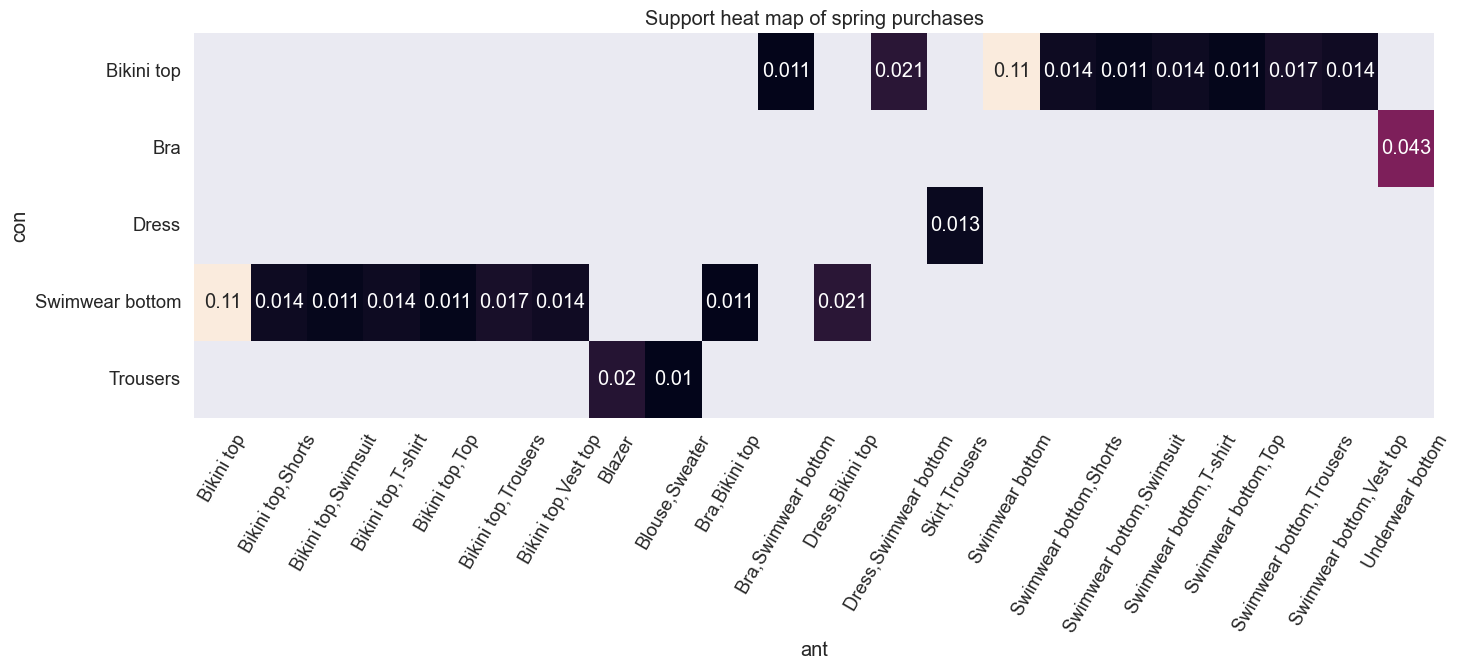

In [22]:
#plotting spring

table = seasonal_rules['spring'].pivot(index='con', columns='ant', values='support')

plt.figure(figsize=(16,5))
sns.set(font_scale=1.2)
sns.heatmap(table, annot=True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=60)
plt.title('Support heat map of spring purchases')
plt.show() 

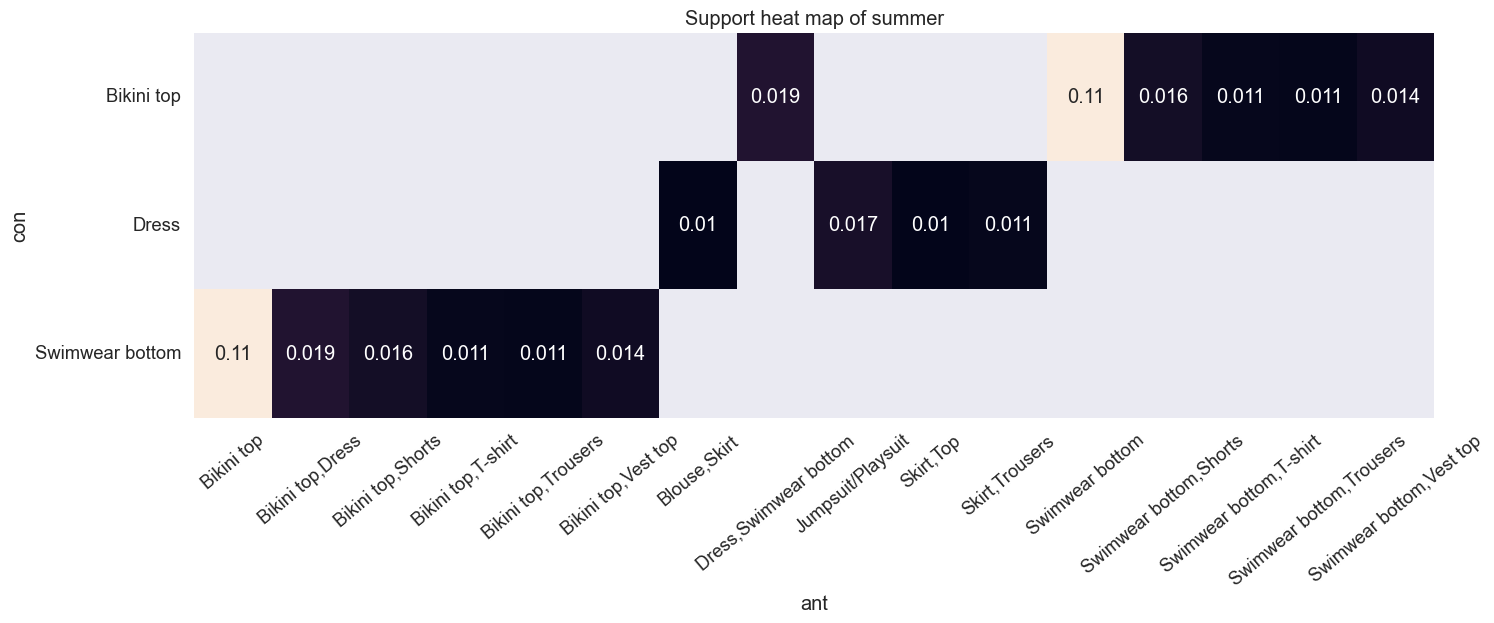

In [23]:
#plotting summer

table = seasonal_rules['summer'].pivot(index='con', columns='ant', values='support')

plt.figure(figsize=(16,5))
sns.set(font_scale=1.2)
sns.heatmap(table, annot=True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=40)
plt.title('Support heat map of summer')
plt.show() 

In [24]:
#plotting fall

table = seasonal_rules['fall'].pivot(index='con', columns='ant', values='support')

plt.figure(figsize=(16,5))
sns.set(font_scale=1.2)
sns.heatmap(table, annot=True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=40)
plt.title('Support heat map of fall purchases')
plt.show() 

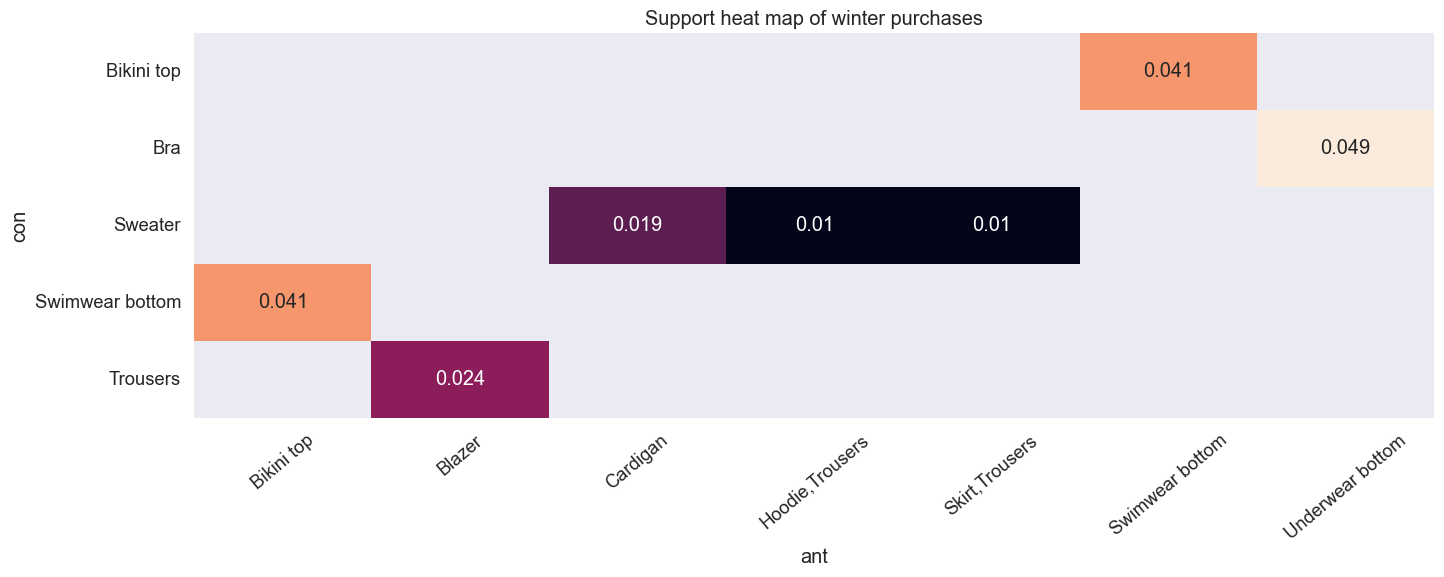

In [25]:
#plotting winter

table = seasonal_rules['winter'].pivot(index='con', columns='ant', values='support')

plt.figure(figsize=(16,5))
sns.set(font_scale=1.2)
sns.heatmap(table, annot=True, cbar=False)
plt.yticks(rotation=0)
plt.xticks(rotation=40)
plt.title('Support heat map of winter purchases')
plt.show() 

#### Heatmaps of lift

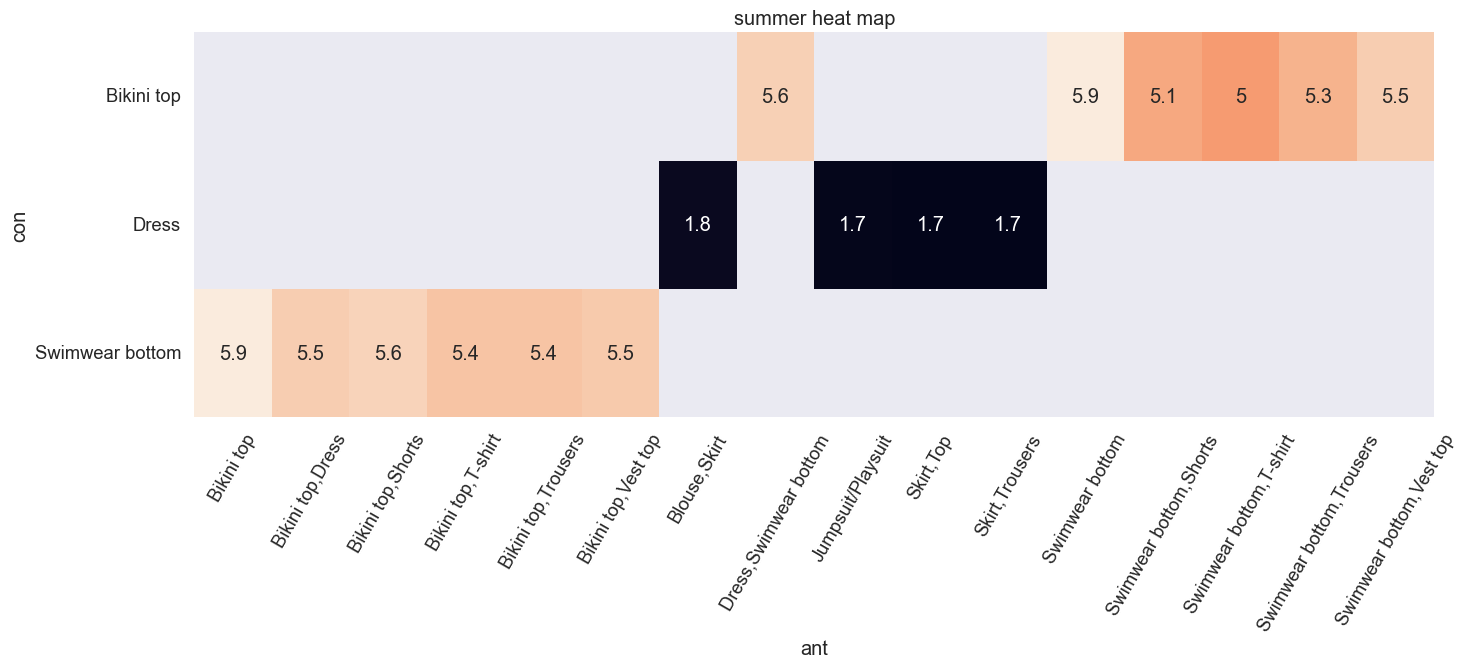

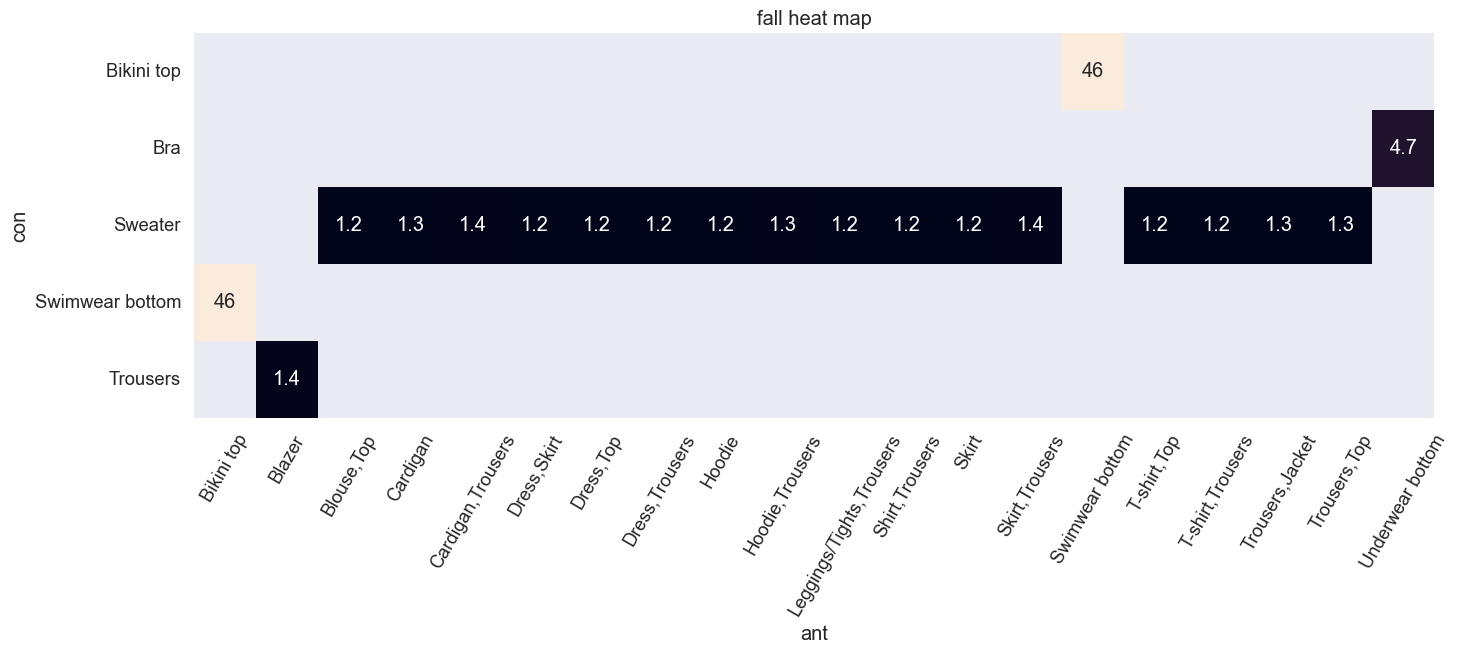

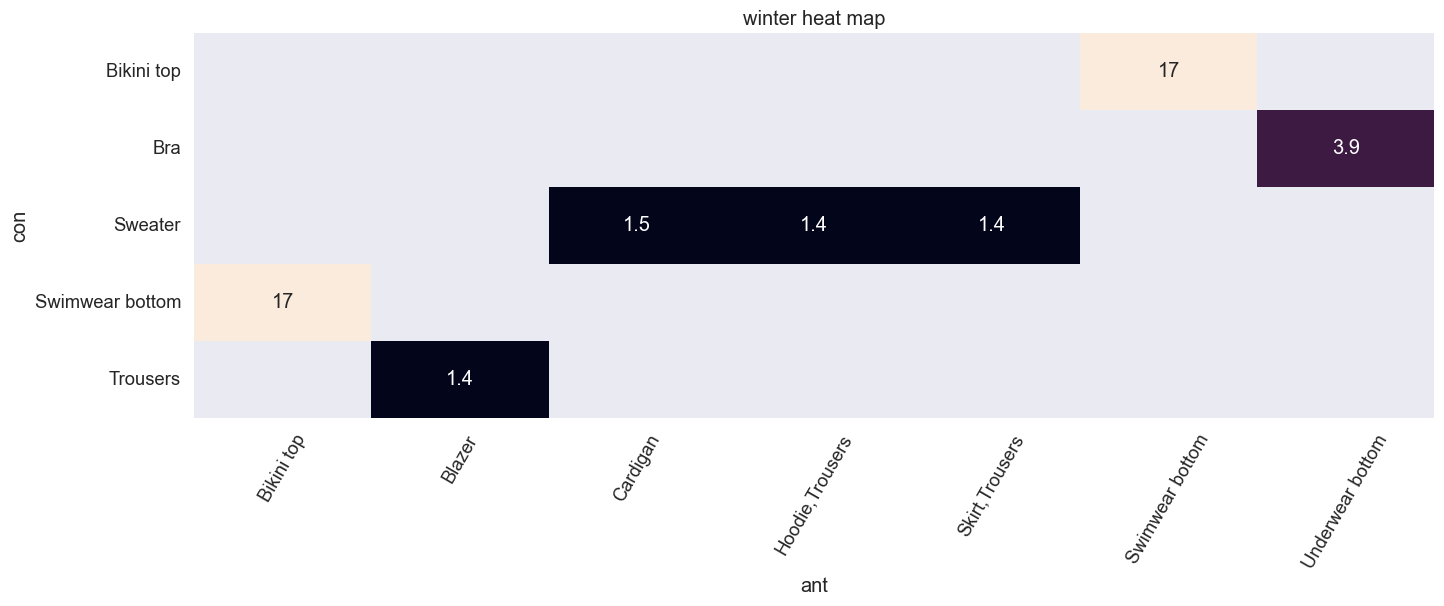

In [26]:
#plotting
for season in seasons:
    table = seasonal_rules[season].pivot(index='con', columns='ant', values='lift')

    plt.figure(figsize=(16,5))
    sns.heatmap(table, annot=True, cbar=False)
    plt.yticks(rotation=0)
    plt.xticks(rotation=60)
    plt.title(season + ' heat map')
    plt.show() 

## Monthly Itemsets

In [27]:
m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthly_baskets = []

#create a list of dataframe where each element corresponds to the baskets of each month 
for month in months:
    monthly_baskets.append(baskets[baskets['month'] == month])


In [28]:
monthly_purchases = []

#create a list where each element is a list of transactions for a given month
for basket in monthly_baskets:
    monthly_purchases.append(map_baskets(create_baskets_list(basket), product_type_map))

In [29]:
monthly_supports = {}
monthly_rules = {}

#apply the apriori algorithm and association rules to each month
#store the results in a dictionary
for key, value in zip(m, monthly_purchases):
    apr = apply_apriori(value)
    monthly_supports[key] = apr
    monthly_rules[key] = apply_association_rules(apr, 0.45)

In [30]:
monthly_rules['dec']

antecedents        consequents  antecedent support  \
3        (Bikini top)  (Swimwear bottom)            0.017575   
4   (Swimwear bottom)       (Bikini top)            0.017675   
6  (Hoodie, Trousers)          (Sweater)            0.020617   
2          (Cardigan)          (Sweater)            0.040975   
5   (Skirt, Trousers)          (Sweater)            0.022832   
0  (Underwear bottom)              (Bra)            0.097548   
1            (Hoodie)          (Sweater)            0.058536   
7      (T-shirt, Top)          (Sweater)            0.022260   

   consequent support   support  confidence       lift  leverage  conviction  
3            0.017675  0.013816    0.786092  44.475849  0.013505    4.592277  
4            0.017575  0.013816    0.781684  44.475849  0.013505    4.500019  
6            0.355381  0.010261    0.497697   1.400461  0.002934    1.283327  
2            0.355381  0.020247    0.494130   1.390425  0.005685    1.274279  
5            0.355381  0.011254    0.492902   1.386968  0.003140    1.271192  
0            0.117006  0.047193    0.483799   4.134816  0.035780    1.710561  
1            0.355381  0.026614    0.454661   1.279363  0.005811    1.182052  
7            0.355381  0.010081    0.452884   1.274364  0.002170    1.178214

### Visualization

#### Heatmap of support

In [31]:
# Convert antecedents and consequents into strings
for month in m:
    monthly_rules[month]['ant'] = monthly_rules[month]['antecedents'].apply(lambda a: ','.join(list(a)))
    monthly_rules[month]['con'] = monthly_rules[month]['consequents'].apply(lambda a: ','.join(list(a)))

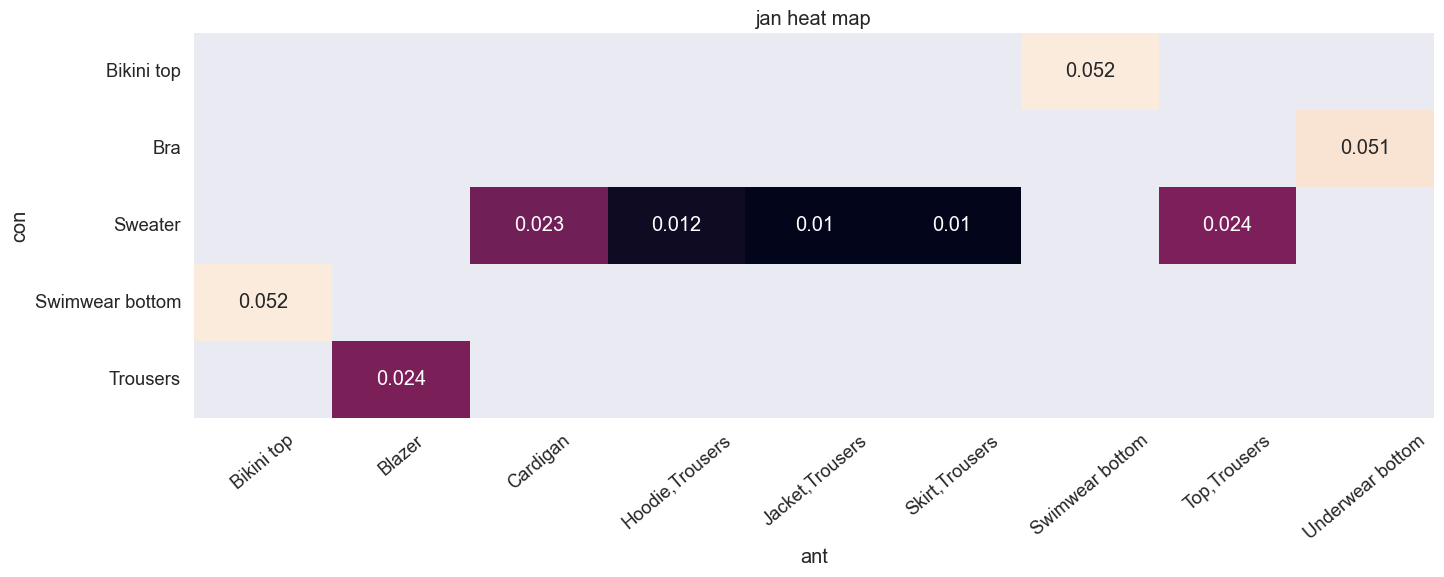

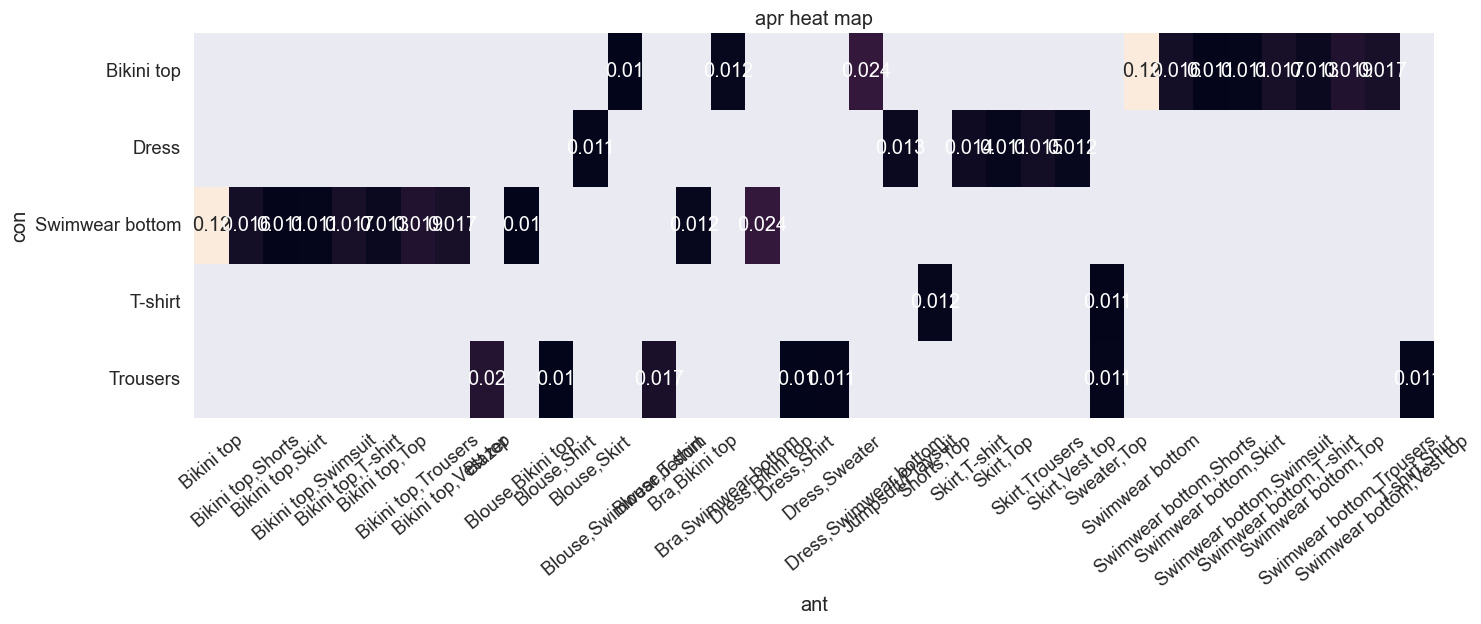

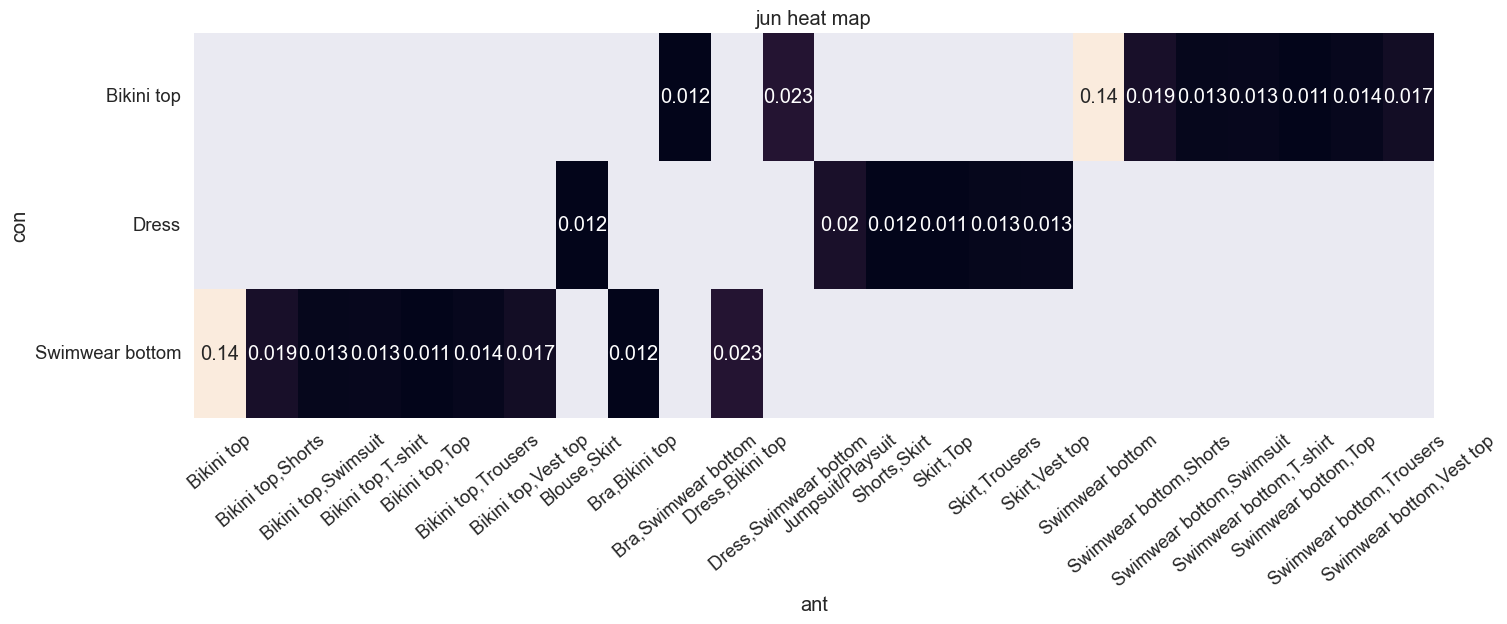

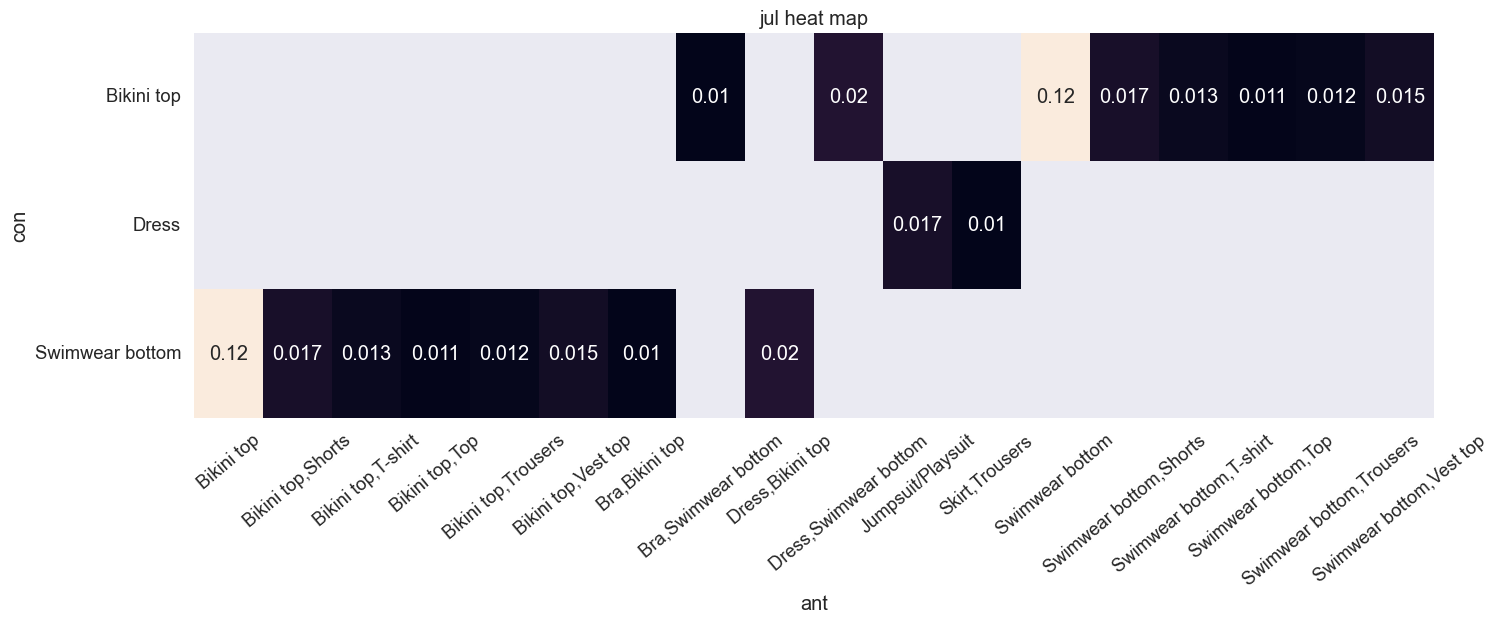

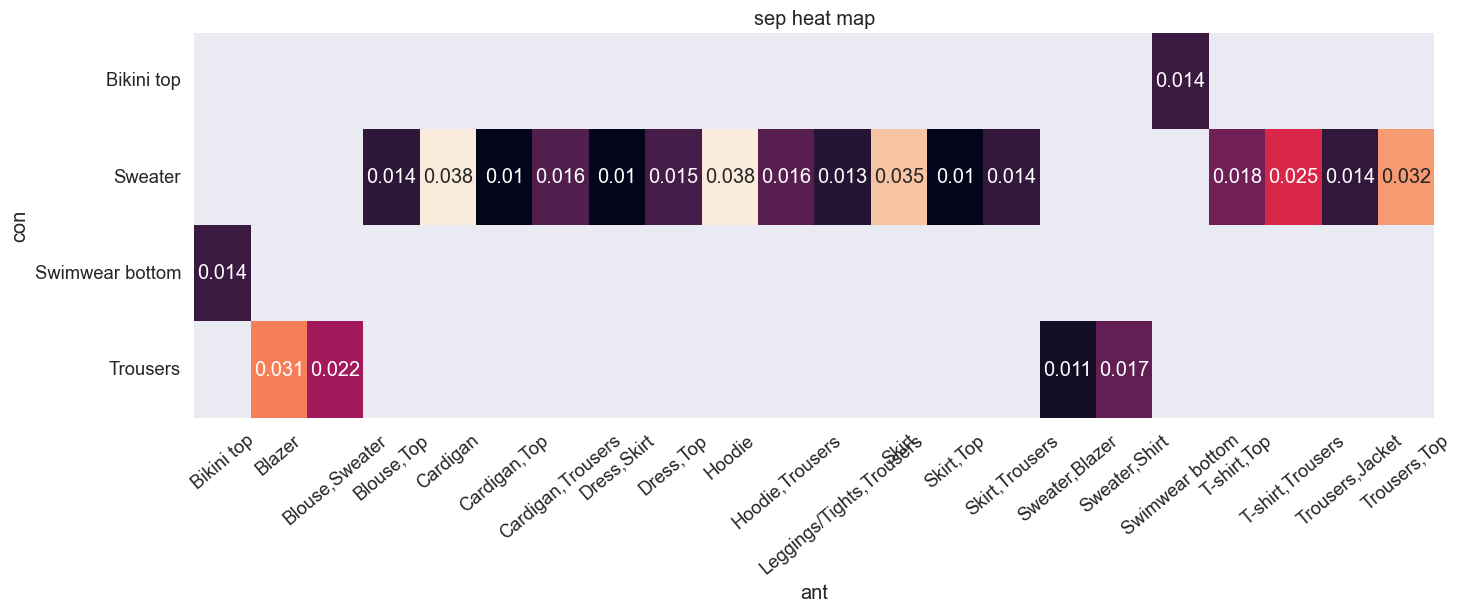

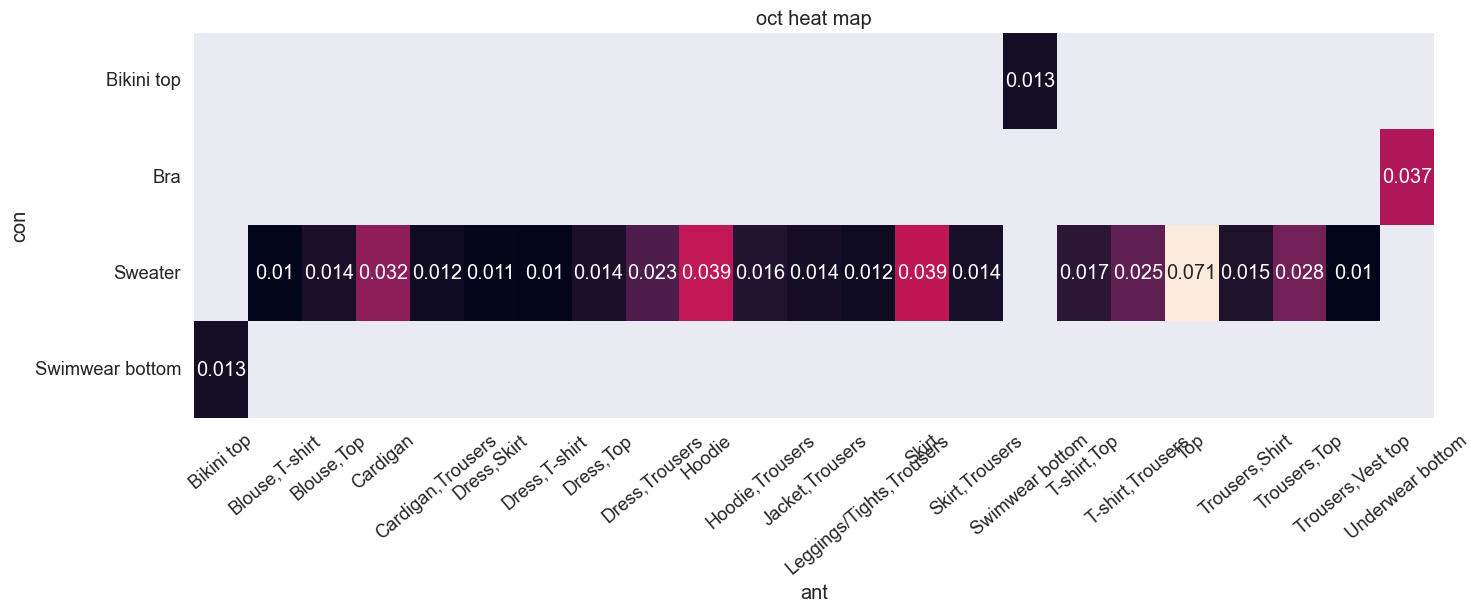

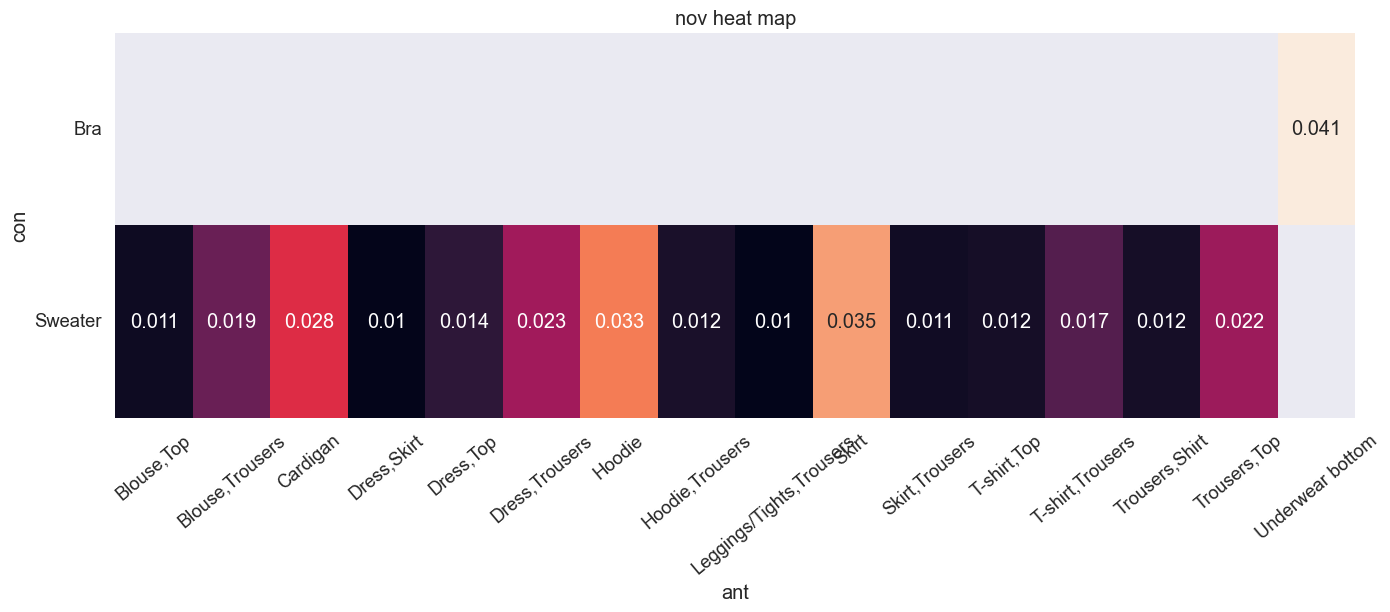

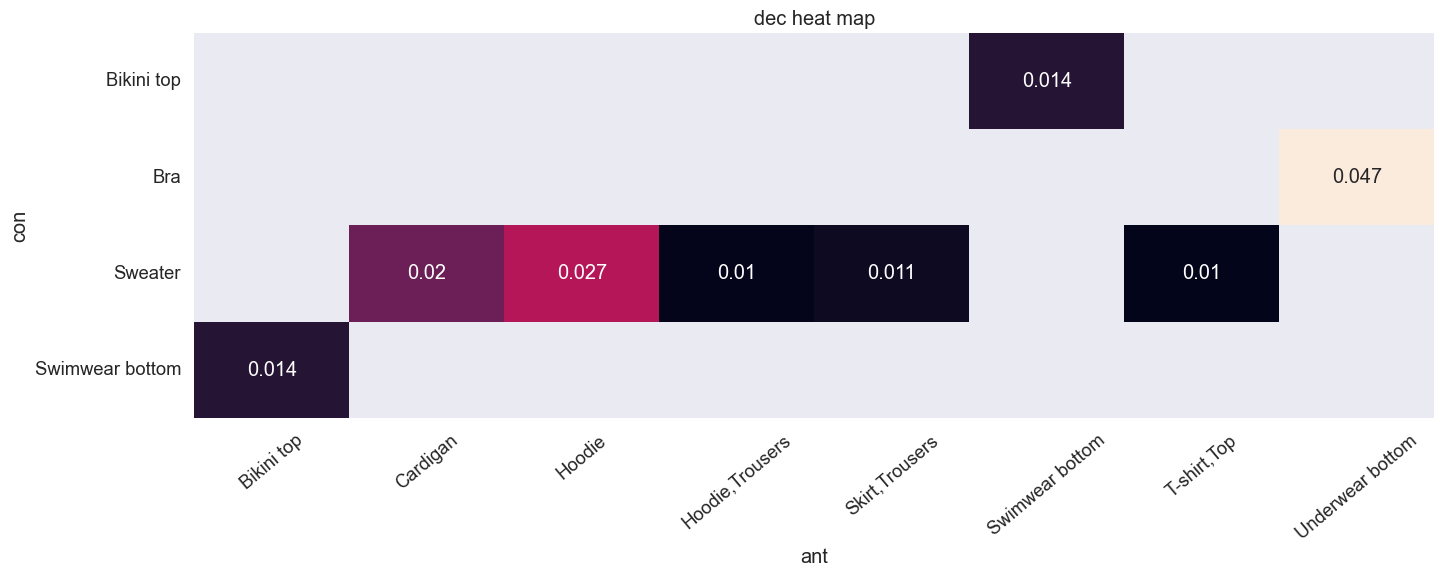

In [32]:
#plotting
for month in m:
    table = monthly_rules[month].pivot(index='con', columns='ant', values='support')

    plt.figure(figsize=(16,5))
    sns.heatmap(table, annot=True, cbar=False)
    plt.yticks(rotation=0)
    plt.xticks(rotation=40)
    plt.title(month + ' heat map')
    plt.show() 

#### Heatmaps with Lift

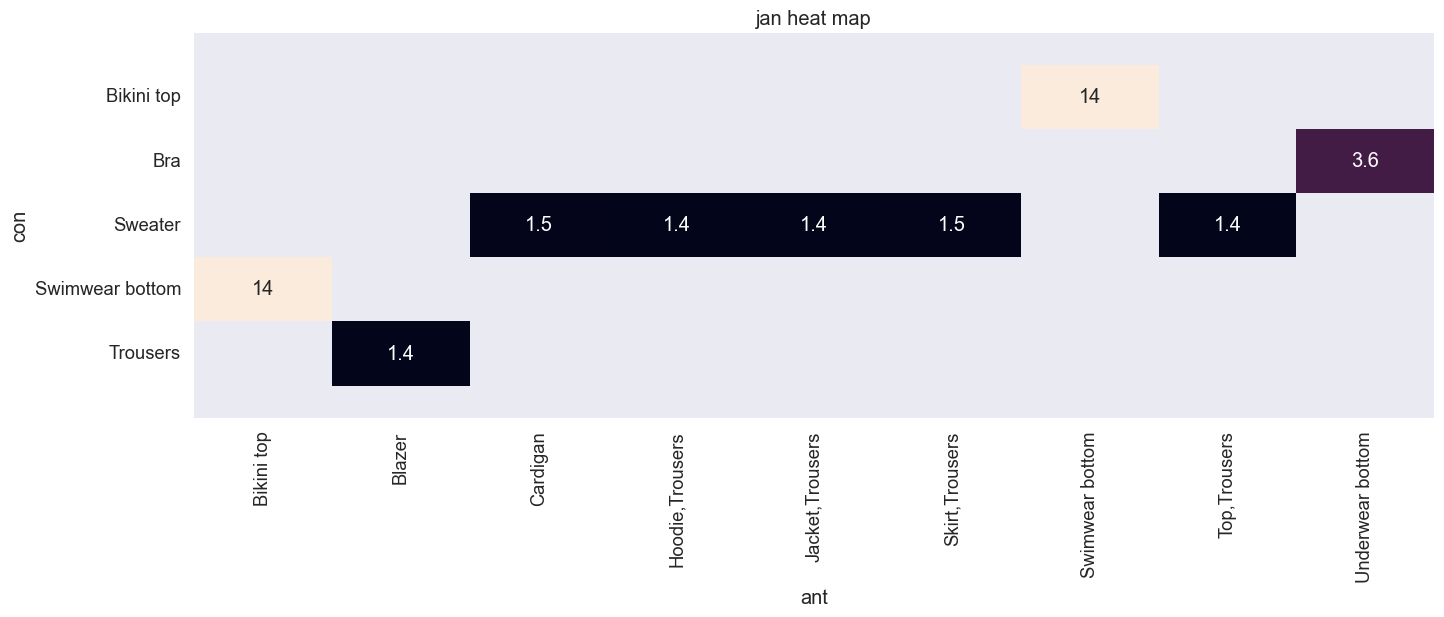

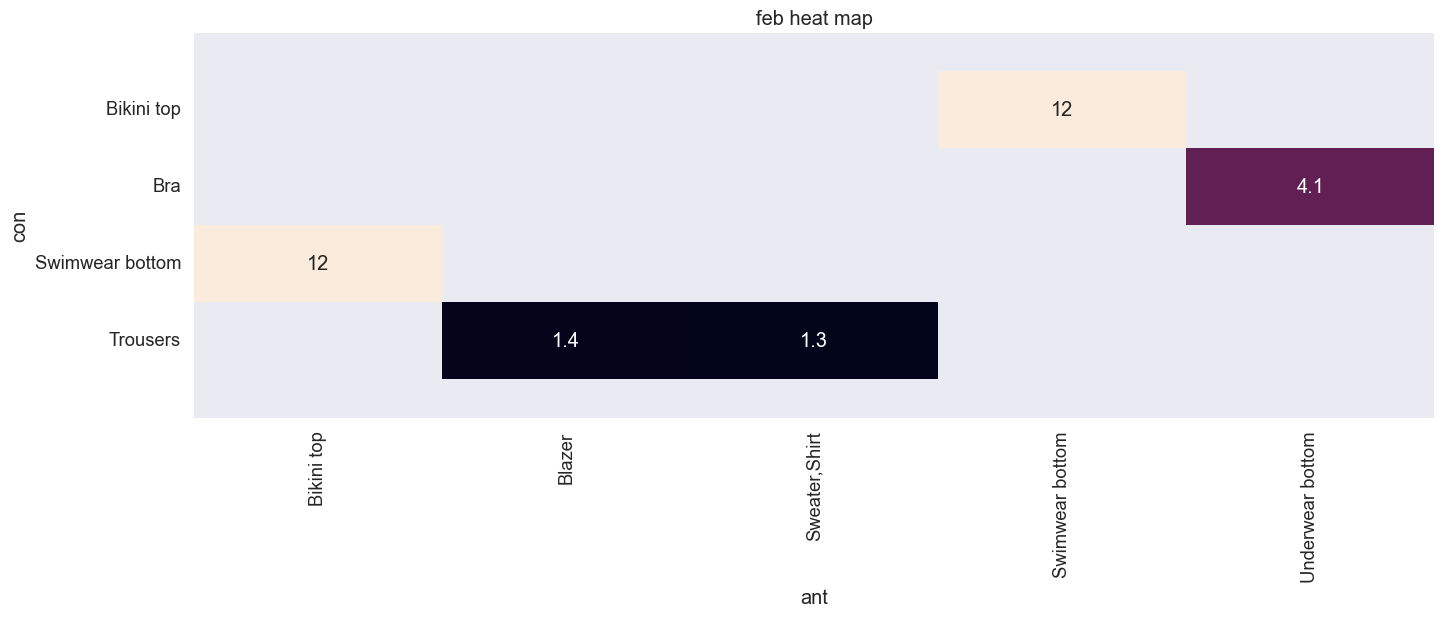

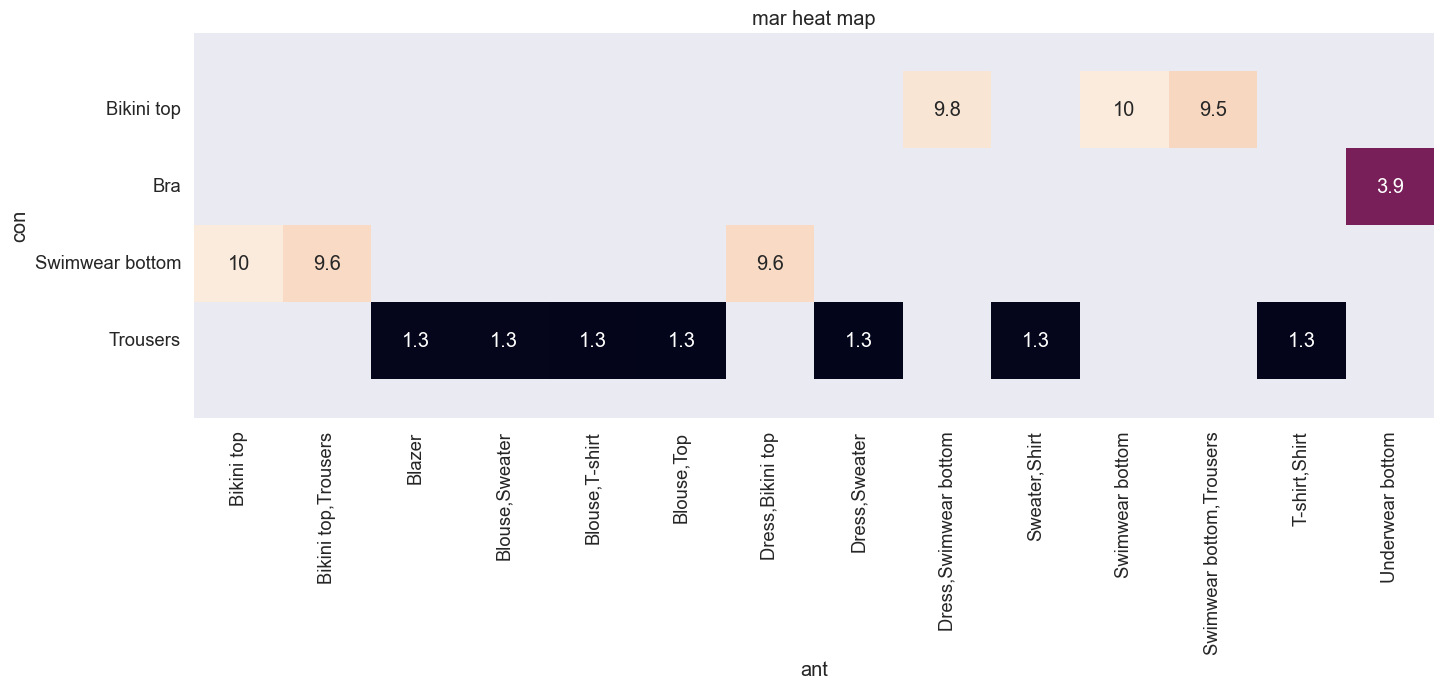

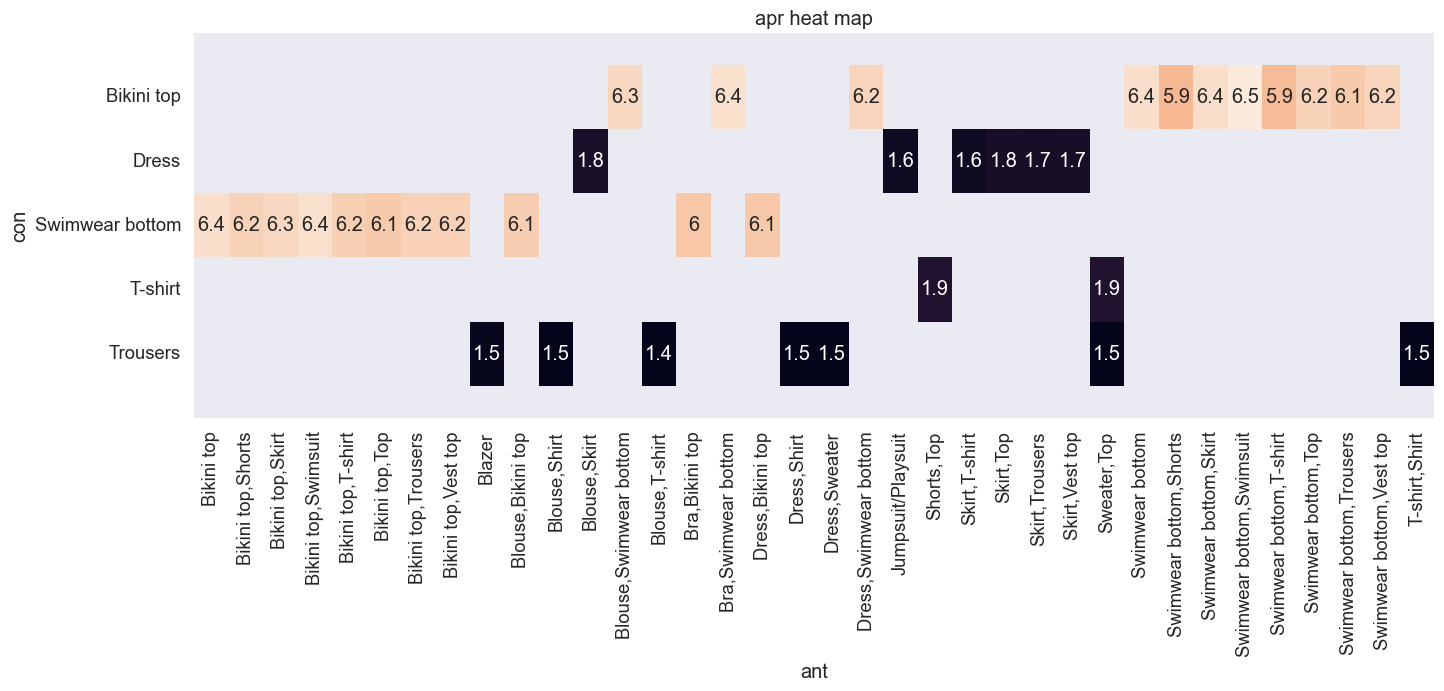

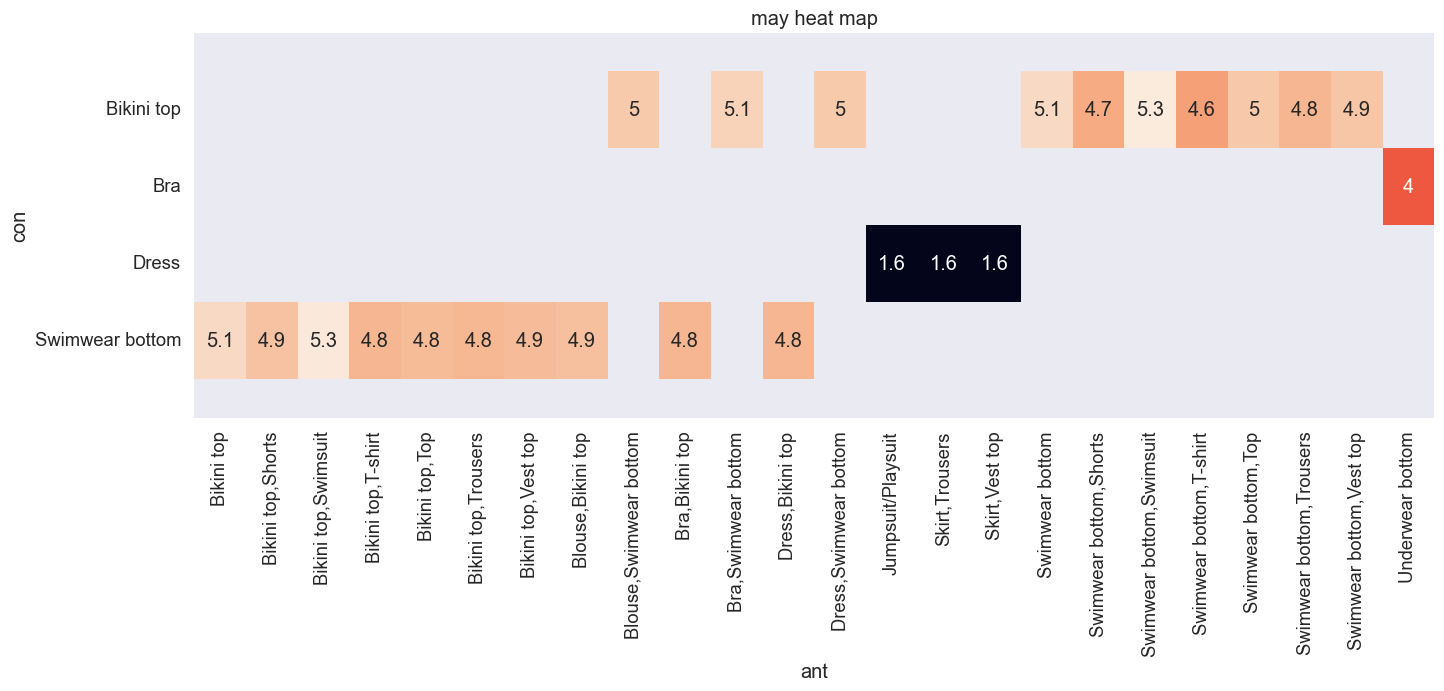

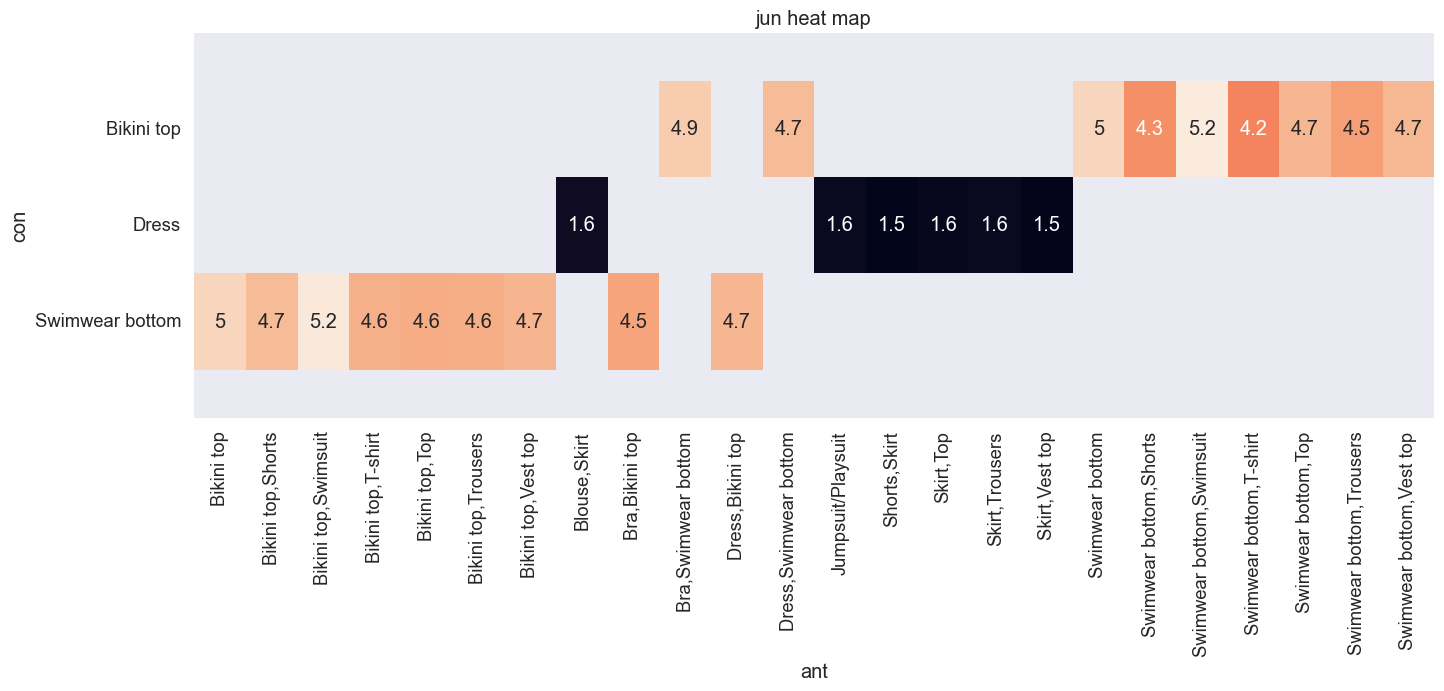

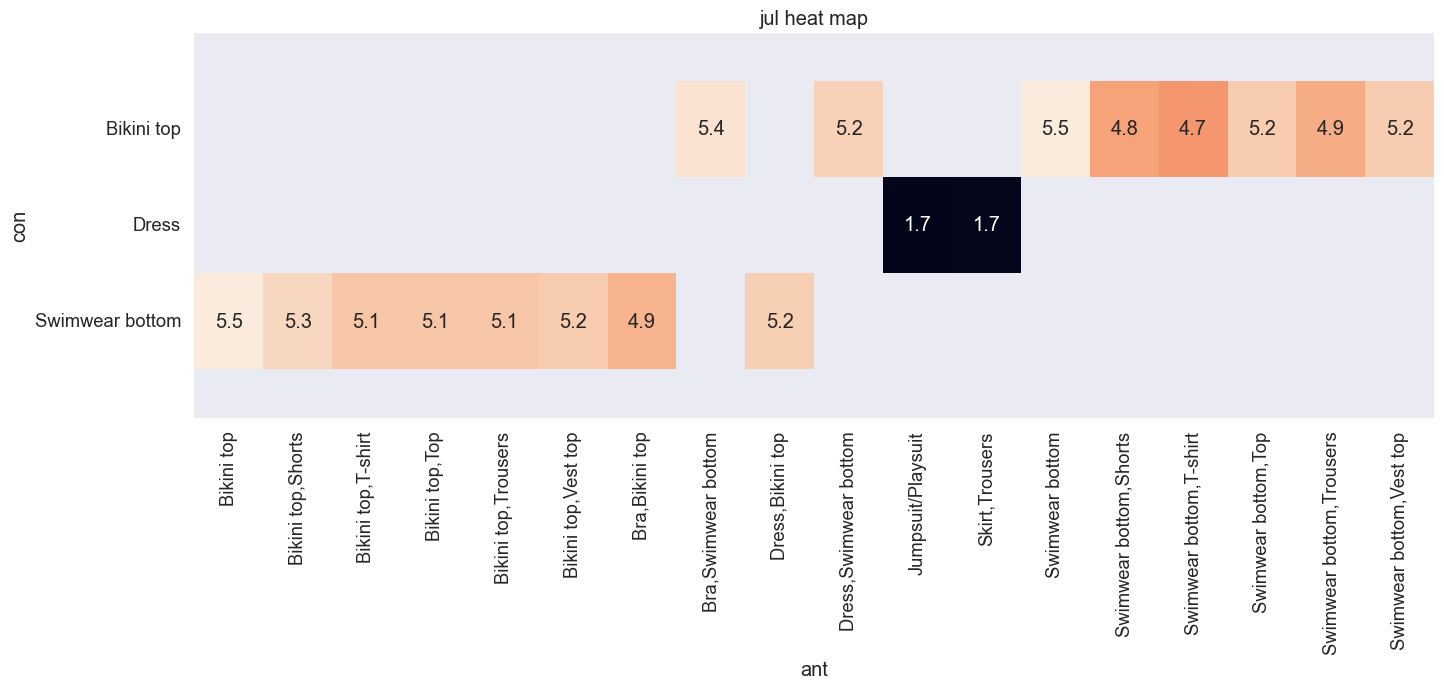

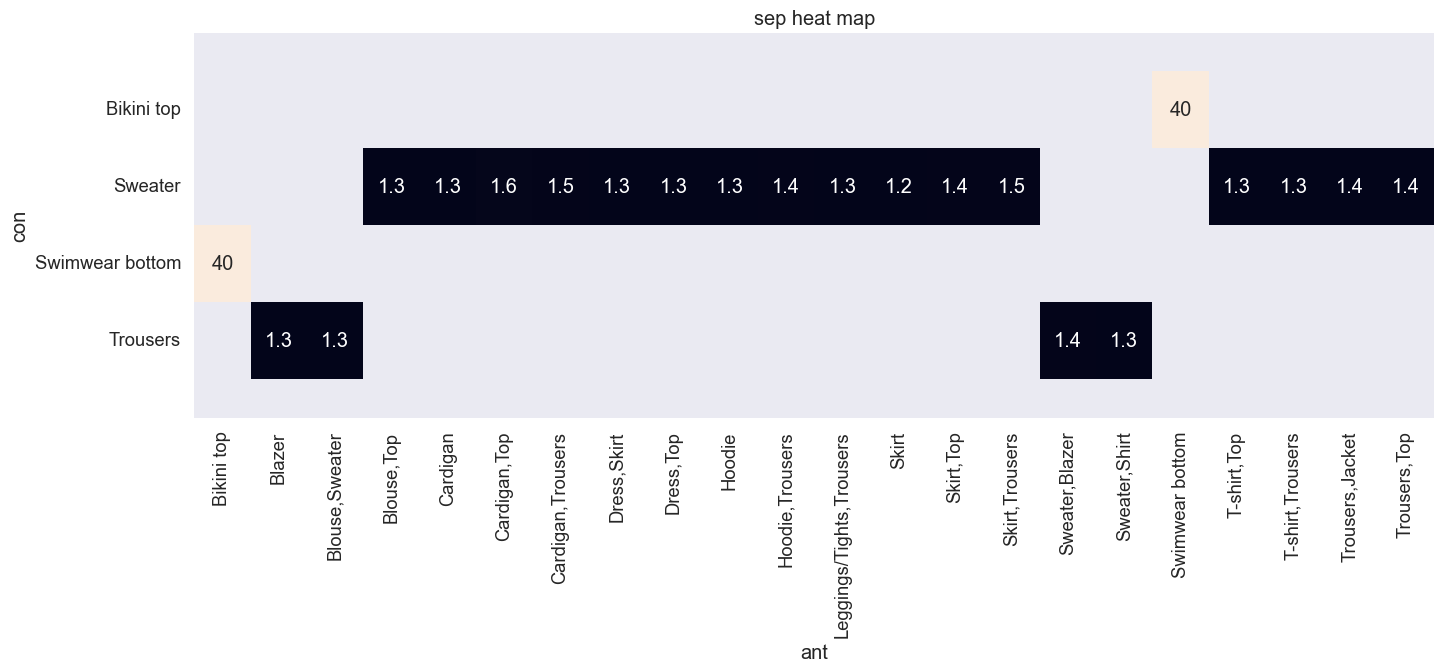

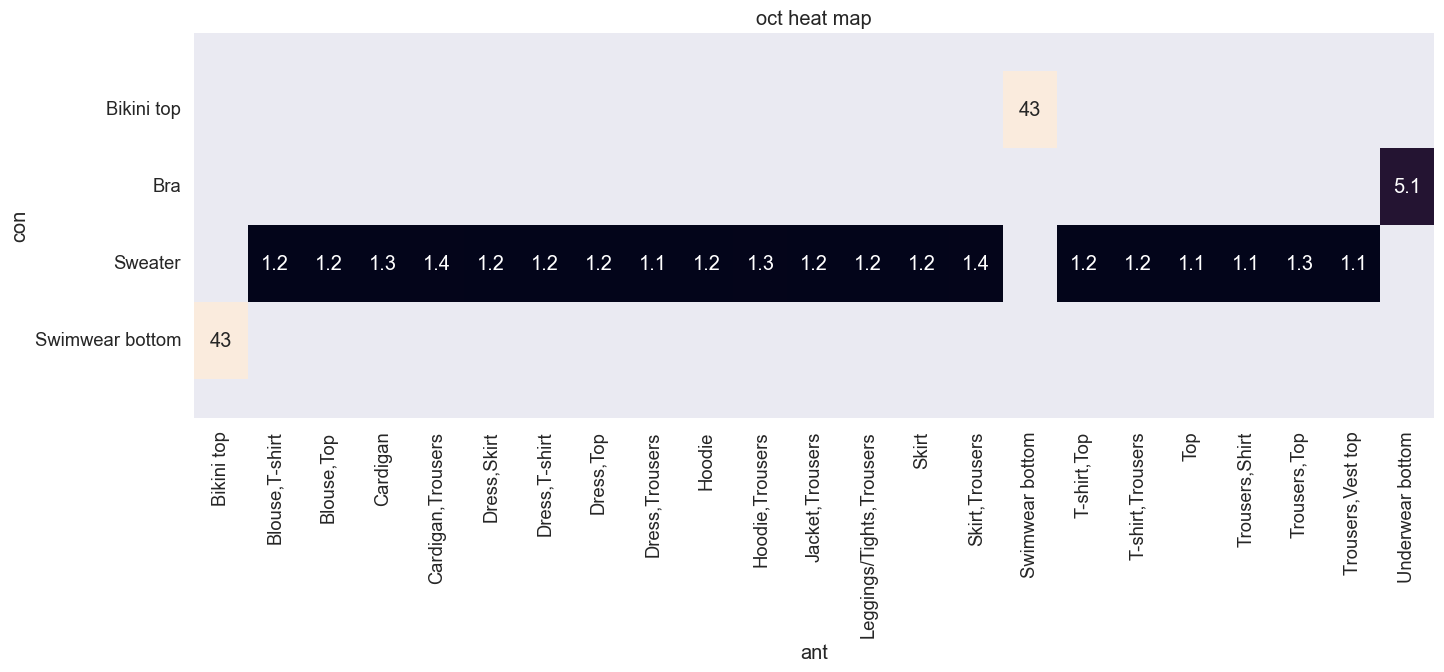

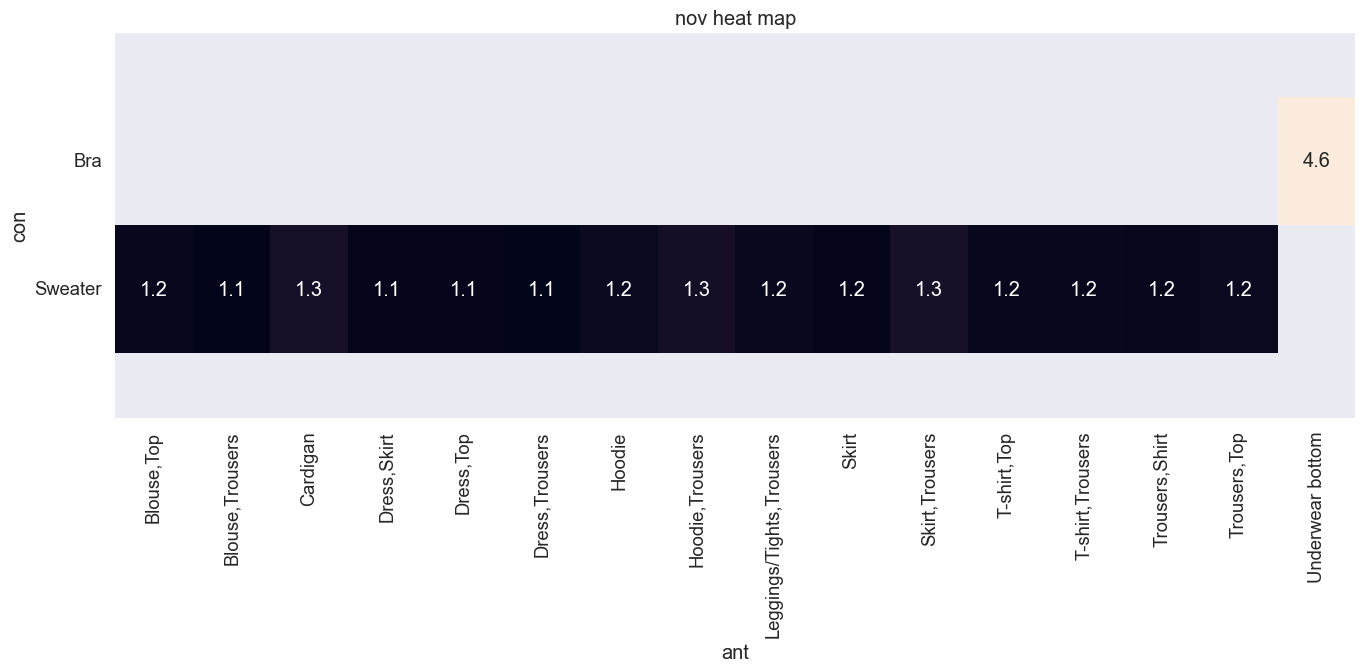

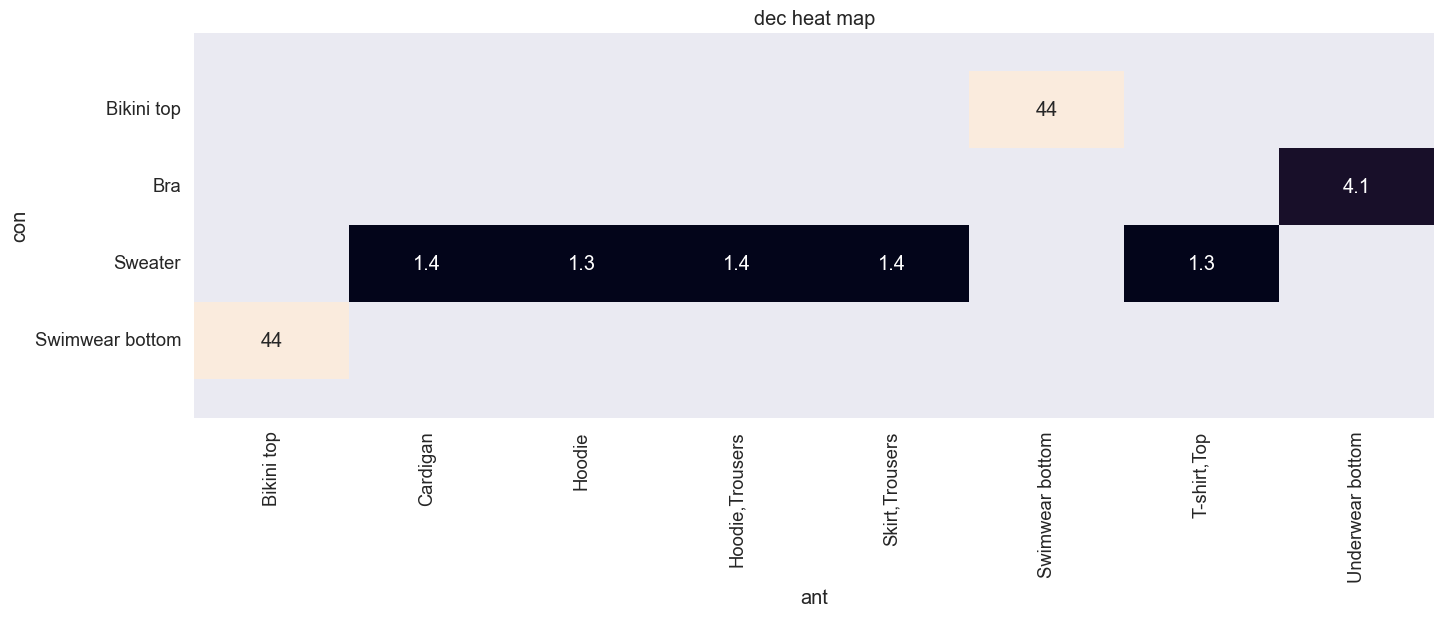

In [33]:
for month in m:
    pivot = monthly_rules[month].pivot(index = 'con', columns = 'ant', values= 'lift')

    plt.figure(figsize=(16,5))
    sns.heatmap(pivot, annot = True, cbar = False)
    b, t = plt.ylim() 
    b += 0.5 
    t -= 0.5 
    plt.ylim(b, t) 
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(month + ' heat map')
    plt.show()

#### Parallel coordinates plot

In [34]:
def map_monthly_points(month):
    month['antecedent'] = month['antecedents'].apply(lambda x: list(x)[0])
    month['consequent'] = month['consequents'].apply(lambda x: list(x)[0])
    month['rule'] = month.index

    return month[['antecedent','consequent','rule']]

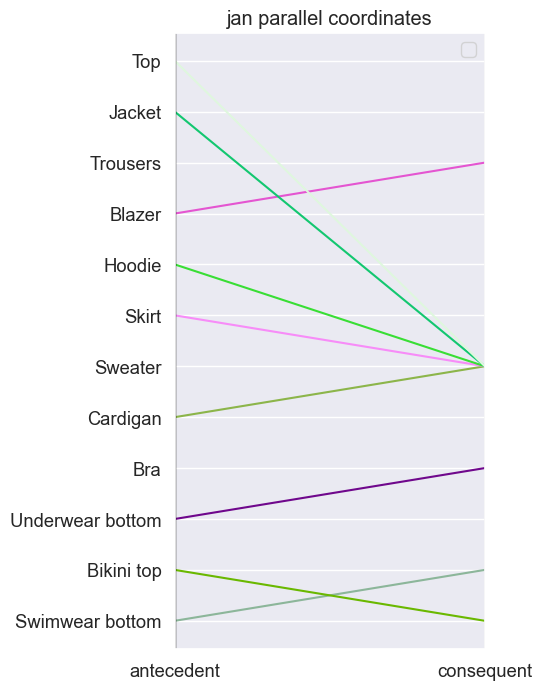

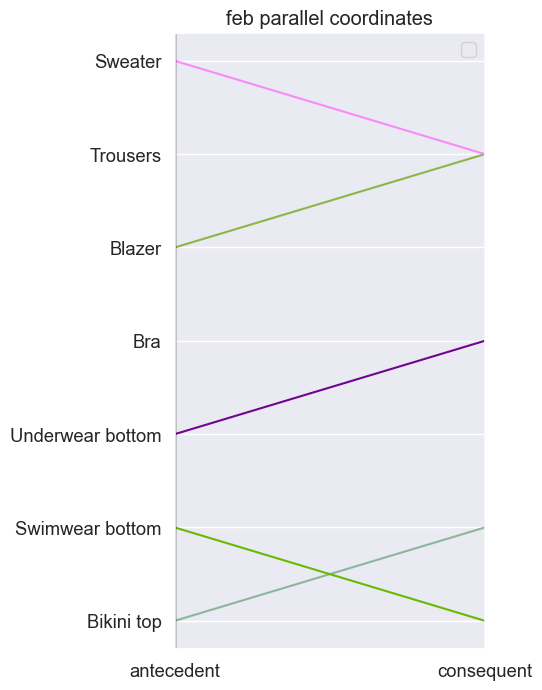

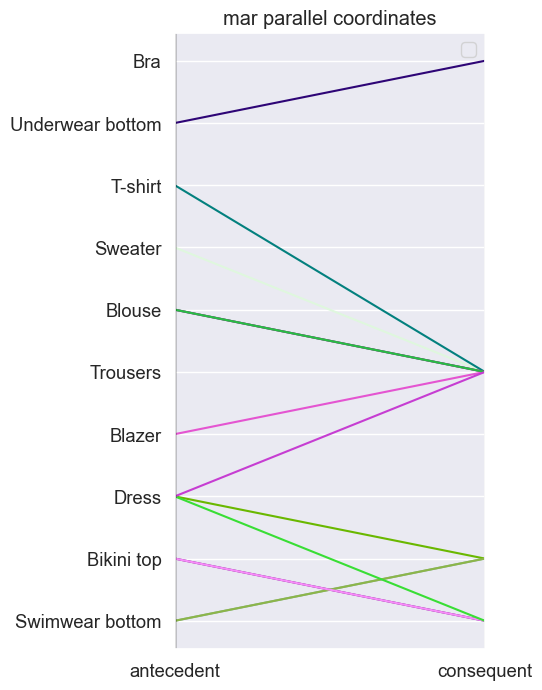

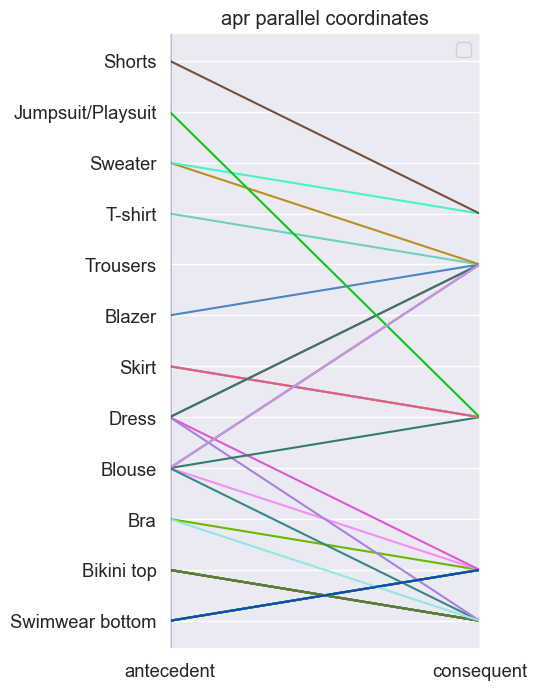

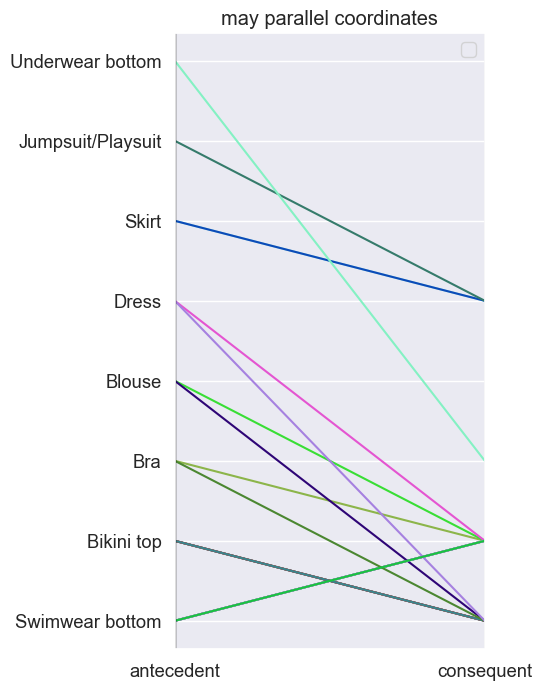

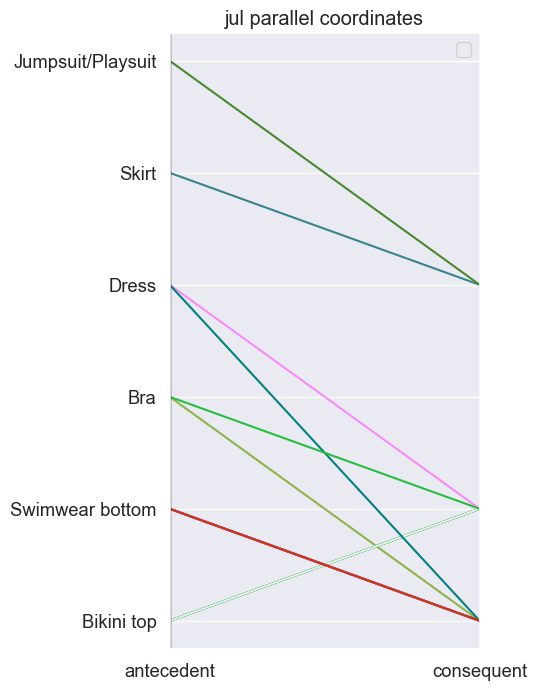

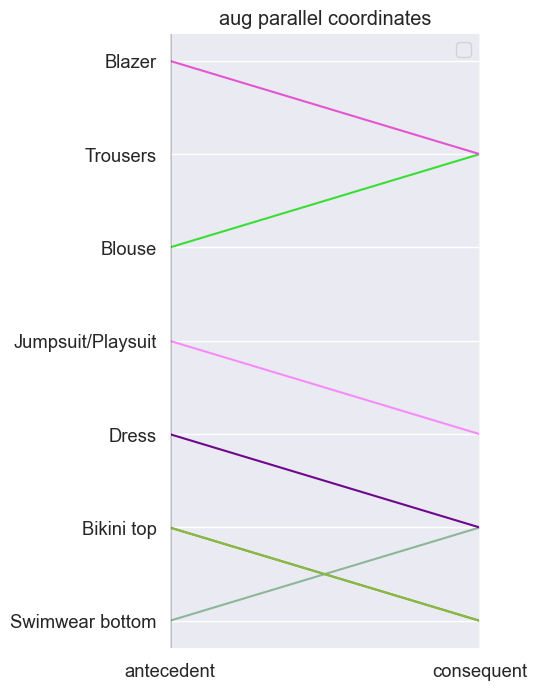

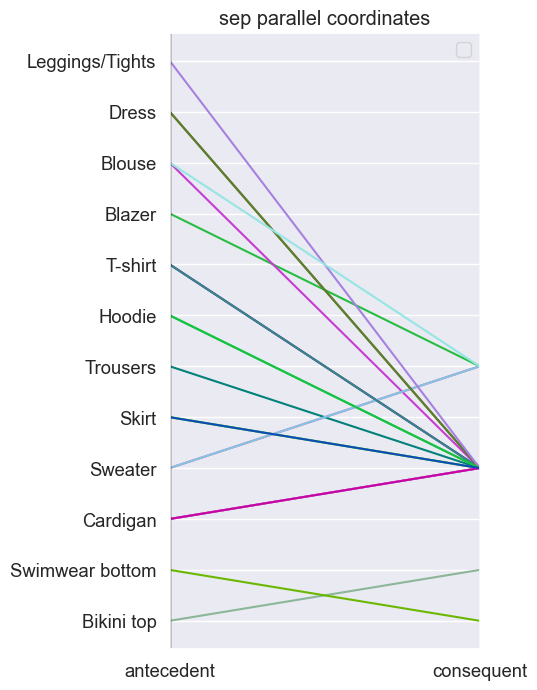

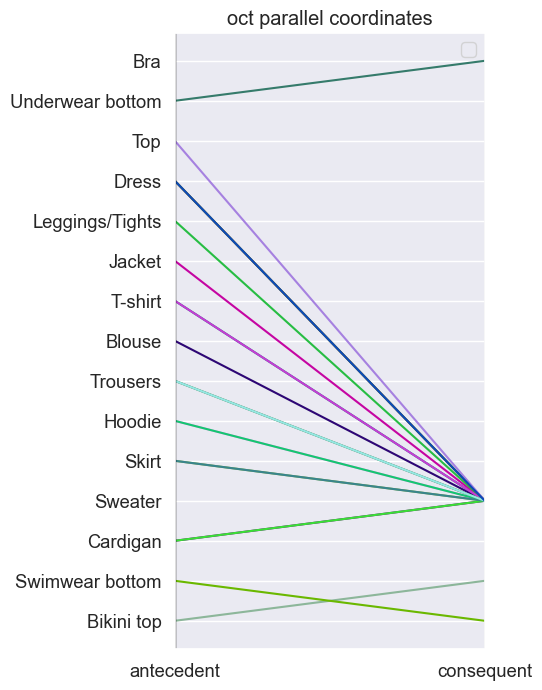

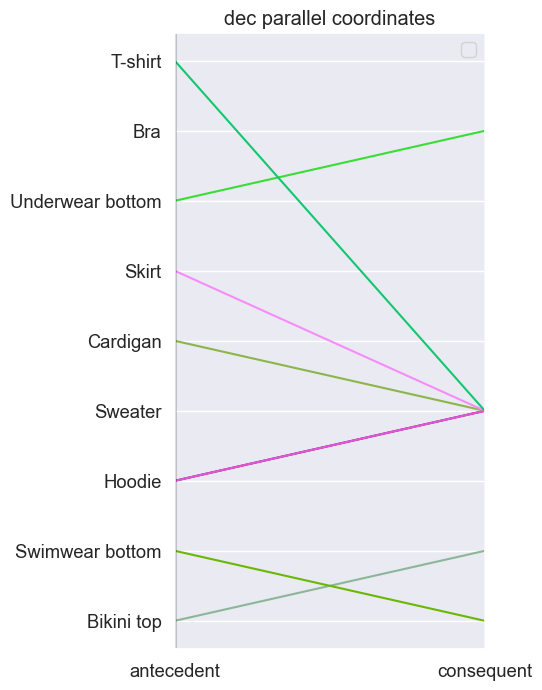

In [35]:
for month in m:
    points = map_monthly_points(monthly_rules[month])

    plt.figure(figsize=(4,8))
    parallel_coordinates(points, 'rule')
    plt.title(month + ' parallel coordinates')
    plt.legend([])
    plt.grid(True)
    plt.show()

In [36]:
m

['jan',
 'feb',
 'mar',
 'apr',
 'may',
 'jun',
 'jul',
 'aug',
 'sep',
 'oct',
 'nov',
 'dec']